## Importing necessary modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
from tqdm import tqdm # Cool progress bar

import random
import numpy as np
import pandas as pd
import sys
import os # read and manipulate local files

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cv2
import seaborn as sns

from PIL import Image

import tensorflow.keras as ks
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K # F1-score metric

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import   Lambda, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import  GlobalAveragePooling2D, Reshape, Multiply, Attention, add,Resizing,  Input, Dense
from tensorflow.keras.layers import Activation,AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

# hide wornings
import warnings
warnings.filterwarnings('ignore')

# from keras import ops# For deeplab3

# import keras_cv # basnet

# from imgaug import augmenters as iaa ## for augmentation

## Defining paths

In [ ]:
model_name = 'Basic_Unet_616'

################################################################################################
## SETTING THE PATHS
PATH_TO_CODE ='/content/drive/MyDrive/TRIAL_v1/segmentation_task'
# PATH_TO_CODE =''
sys.path.append(PATH_TO_CODE)

# DATASET_PATH = r'C:\Users\ASUS\Desktop\segmentation & cropping\segmentation_task\segmentation_data43_resized_cropped_split'
DATASET_PATH = r'/content/drive/MyDrive/TRIAL_v1/segmentation_task/segmentation_data43_resized_cropped_split'
# DATASET_PATH = r'segmentation_data43_resized_cropped_split'
DATASET_PATH_TRAIN = os.path.join(DATASET_PATH, 'train')
DATASET_PATH_TEST = os.path.join(DATASET_PATH, 'test')


PATH_TO_SAVE_RESULT = os.path.join(PATH_TO_CODE, 'saved_outputs_segmentation_AUC', model_name)
PATH_BEST_SAVE_WEIGHT = os.path.join(PATH_TO_SAVE_RESULT,'saved_weights')
PATH_TO_SAVE_MODEL = os.path.join(PATH_TO_SAVE_RESULT, 'saved_models')
PATH_SAVE_HISTORY = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_training_history.csv')
PATH_SAVE_TIME = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_training_time.csv')
PATH_SAVE_AUGMENT_SAMPLE = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_augmented_sample.pdf')
PATH_SAVE_PIXEL_PERCENTAGE_PLOT = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_pixel_percentage.pdf')
# PATH_TO_SAVE_TUNER = os.path.join(PATH_TO_RESULT, 'saved_tuner_model')
################################################################################################

if not os.path.exists(PATH_TO_SAVE_RESULT):
 # If it does not exist, create it
    os.makedirs(PATH_TO_SAVE_RESULT)
################################################################################################
IMG_HEIGHT = 256
IMG_WIDTH = 256
ORIGINAL_IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
COLOR_CHANNEL = 3

RESIZE_SHAPE = ORIGINAL_IMAGE_SIZE #(128, 128) #ORIGINAL_IMAGE_SIZE#(128, 128)# # #ORIGINAL_IMAGE_SIZE# (128, 128)#
MODEL_INPUT_SIZE = (RESIZE_SHAPE[0], RESIZE_SHAPE[1], COLOR_CHANNEL)

VALIDATION_SPLIT= 0.2
NUM_CLASSES = 2 # Disease and not disease

BATCH_SIZE = 10
EPOCHS = 20

TOTAL_DATA = 616
################################################################################################

################################################################################################

SAVE_RESULTS = True
SHOW_RESULTS = True

################################################################################################
# Setting the seed
SEED  = 123
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

################################################################################################
# Checkpoint parameters val_binary_io_u
SCORE_TO_MONITOR = 'val_binary_io_u' # Score that checkpoints monitor during training
SCORE_OBJECTIVE  = 'max'          # 'max' or 'min', specifies whether the objective is to maximize the score or minimize it.
PATIENCE_LR_REDUCE = 5
MIN_LR = 1e-8
REDUCTION_FACTOR = 0.5            # Factor which lr will be reduced with at plateau
COOLDOWN_EPOCHS  = 2 #cooldown: Integer. Number of epochs to wait before resuming normal operation after the learning rate has been reduced.

INITIAL_LR = 0.001

## Defining performance metrics

Official segmentation metrics by keras: https://ks.io/api/metrics/segmentation_metrics/

In [ ]:
def f1_score(y_true, y_pred): # Dice coefficient
    """
    Calculate the F1 score, the harmonic mean of precision and recall, for binary classification.

    Args:
        y_true (Tensor): True binary labels.
        y_pred (Tensor): Predicted probabilities.

    Returns:
        float32: F1 score as a scalar.
    """
    # True Positives: round product of y_true and y_pred
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    # Actual Positives: round y_true
    P = K.sum(K.round(K.clip(y_true, 0, 1)))
    # Recall: TP / Actual Positives
    recall = TP / (P + K.epsilon())

    # Predicted Positives: round y_pred
    Pred_P = K.sum(K.round(K.clip(y_pred, 0, 1)))
    # Precision: TP / Predicted Positives
    precision = TP / (Pred_P + K.epsilon())

    # F1 Score: harmonic mean of precision and recall
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# source: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryIoU
iou_score_binary = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)

def accuracy_score(y_true, y_pred):
    """
    Calculate accuracy score between two binary masks.
    """
    correct = np.sum(y_true == y_pred)  # Count correct predictions
    total = y_true.size  # Total number of pixels
    return correct / total  # Accuracy calculation

def precision_score(groundtruth_mask, pred_mask):
    """
    Calculate precision score between two binary masks.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)  # Calculate intersection
    total_pixel_pred = np.sum(pred_mask)  # Sum of predicted positives
    return np.mean(intersect / total_pixel_pred)  # Precision calculation

def recall_score(groundtruth_mask, pred_mask):
    """
    Calculate recall score between two binary masks.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)  # Calculate intersection
    total_pixel_truth = np.sum(groundtruth_mask)  # Sum of actual positives
    return np.mean(intersect / total_pixel_truth)  # Recall calculation

## Reading the data

In [ ]:
# Function to read images from a directory using Pillow
def read_images_from_directory(directory_path):
    images = []
    for filename in sorted(os.listdir(directory_path)):
        # filename= filename.lower()

        if filename.endswith(('.png', '.jpg', '.JPG' )):  # Check for image file extensions
            img_path = os.path.join(directory_path, filename)
            img = Image.open(img_path)
            img_array = np.array(img)  # Convert the image to a numpy array if needed
            if img_array is not None:
                images.append(img_array)
    return images

# Paths to masks and original images within the dataset
masks_path_train = os.path.join(DATASET_PATH_TRAIN, 'data43_masks_binarised')
originals_path_train = os.path.join(DATASET_PATH_TRAIN, 'data43_original')

# Read images into variables
x_train = read_images_from_directory(originals_path_train)  # Original images
y_train = read_images_from_directory(masks_path_train)  # Masks

# Paths to masks and original images within the test dataset
masks_path_test = os.path.join(DATASET_PATH_TEST, 'data43_masks_binarised')
originals_path_test = os.path.join(DATASET_PATH_TEST, 'data43_original')

# Read images into variables
x_test = read_images_from_directory(originals_path_test)  # Original images
y_test = read_images_from_directory(masks_path_test)  # Masks

# Now x_train contains original images, and y_train contains mask images
print(f"Loaded {len(x_train)} original images into x_train")
print(f"Loaded {len(y_train)} mask images into y_train")

# Similarly, for test images
print(f"Loaded {len(x_test)} original images into x_test")
print(f"Loaded {len(y_test)} mask images into y_test")

Loaded 616 original images into x_train
Loaded 616 mask images into y_train
Loaded 23 original images into x_test
Loaded 23 mask images into y_test


## Preprocessing DO NOT RESIZE THE IMAGE-- IT GIVES FINE LINES IN THE OUTPUT

In [ ]:
# # # Resizing
# x_train = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in x_train]
# y_train = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in y_train]

# x_test = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in x_test]
# y_test = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in y_test]

# Convert the list to a NumPy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Expand mask dimensions to (batch, 256, 256, 1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)


# Normalizing input between [0,1]
x_train = x_train.astype("float32")/ np.max(x_train)
x_test  = x_test.astype("float32")/np.max(x_test)

y_train = y_train.astype("float32")/ np.max(y_train)
y_test  = y_test.astype("float32")/np.max(y_test)

# Now x_train contains original images, and y_train contains mask images
print(f"Loaded {len(x_train)} original images into x_train")
print(f"Loaded {len(y_train)} mask images into y_train")

# Similarly, for test images
print(f"Loaded {len(x_test)} original images into x_test")
print(f"Loaded {len(y_test)} mask images into y_test")

Loaded 616 original images into x_train
Loaded 616 mask images into y_train
Loaded 23 original images into x_test
Loaded 23 mask images into y_test


## Essential functions

In [ ]:
def fit_and_save_best_model(model_name, model, epochs=EPOCHS):
    ##########################################################################################################
    saved_best_model_name = 'best_'+model_name+'.h5'

    model_saving_path = os.path.join(PATH_TO_SAVE_MODEL, saved_best_model_name)
    # Set up a model checkpoint to save the best model during training
    best_model_callback= ModelCheckpoint(model_saving_path,
                                          monitor=SCORE_TO_MONITOR,
                                          save_best_only=True,
                                          mode=SCORE_OBJECTIVE,
                                          verbose=1)

    reduce_LR = ReduceLROnPlateau(
        factor=REDUCTION_FACTOR,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=PATIENCE_LR_REDUCE, # original was 5      # Number of epochs with no improvement after which learning rate will be reduced.
        verbose=1,       # int. 0: quiet, 1: update messages.
        min_lr=MIN_LR   # Lower bound on the learning rate.
    )

    my_callbacks = [best_model_callback , reduce_LR]
    ##########################################################################################################

    start_time = time.time()

    # Fitting the model
    train_history = model.fit(
        x_train,
        y_train,
        epochs= epochs,
        batch_size=BATCH_SIZE,
        validation_split= VALIDATION_SPLIT,
        callbacks=my_callbacks,
    )
    total_time = time.time() - start_time

    return saved_best_model_name, train_history, total_time

## Models
### Models worked
- Model01: Basic basic_unet
- Model02: unet_vgg16 (my own custom)
- Model03: TransUNet
- Model04: DeepLab-v3Plus
- Model05: ResUNet
- Model06: UNet_with_attention
- Model07: Multi-resUnet
- Model08: Inception_resnetV2 (my own custom)



### Basic basic_unet

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    x = Activation('relu')(x)

    return x

def get_basic_unet(n_filters = 16):
    """
    Version of U-Net with dropout and size preservation (padding= 'same')--from class note
    """
    input_img = Input(shape=MODEL_INPUT_SIZE)
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv2d_block(p4, n_filters * 16, kernel_size=3)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3)

    u9 = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv2d_block(u9, n_filters, kernel_size=3)

    outputs = Conv2D(NUM_CLASSES-1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])

    optimizer = Adam(learning_rate=INITIAL_LR)
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy', f1_score, iou_score_binary],
                  optimizer=optimizer)

    return model

## Train and Results

In [ ]:
model= get_basic_unet() ## Model1
# model= get_unet_vgg16() ## Model2
# model= get_TransUNet() ## Model3
# model= get_DeepLabV3Plus() ## Model4
# model = get_ResUNet_v3() ## Model5
# model = UNet_with_attention() ## Model6
# model = get_multiresunet() ## Model7
# model = get_unet_InceptionResNetV2() ## Model8

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_18[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_20[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_22[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ activation_23[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training the model and saving the best model as a check point
best_model_name, train_history, total_time = fit_and_save_best_model(model_name, model)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9559 - binary_io_u: 0.4779 - f1_score: 0.0000e+00 - loss: 0.2733
Epoch 1: val_binary_io_u improved from -inf to 0.47730, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation_AUC/Basic_Unet_616/saved_models/best_Basic_Unet_616.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - accuracy: 0.9558 - binary_io_u: 0.4779 - f1_score: 0.0000e+00 - loss: 0.2720 - val_accuracy: 0.9546 - val_binary_io_u: 0.4773 - val_f1_score: 0.0000e+00 - val_loss: 0.1312 - learning_rate: 0.0010
Epoch 2/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9560 - binary_io_u: 0.4780 - f1_score: 9.8767e-06 - loss: 0.1154
Epoch 2: val_binary_io_u improved from 0.47730 to 0.48634, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation_AUC/Basic_Unet_616/saved_models/best_Basic_Unet_616.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9559 - binary_io_u: 0.4780 - f1_score: 3.2343e-05 - loss: 0.1154 - val_accuracy: 0.9554 - val_binary_io_u: 0.4863 - val_f1_score: 0.0281 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 3/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9633 - binary_io_u: 0.5749 - f1_score: 0.2574 - loss: 0.0947
Epoch 3: val_binary_io_u improved from 0.48634 to 0.75258, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation_AUC/Basic_Unet_616/saved_models/best_Basic_Unet_616.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9634 - binary_io_u: 0.5773 - f1_score: 0.2629 - loss: 0.0948 - val_accuracy: 0.9771 - val_binary_io_u: 0.7526 - val_f1_score: 0.6034 - val_loss: 0.0808 - learning_rate: 0.0010
Epoch 4/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9732 - binary_io_u: 0.7220 - f1_score: 0.6186 - loss: 0.0819
Epoch 4: val_binary_io_u improved from 0.75258 to 0.77527, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation_AUC/Basic_Unet_616/saved_models/best_Basic_Unet_616.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9731 - binary_io_u: 0.7212 - f1_score: 0.6172 - loss: 0.0822 - val_accuracy: 0.9785 - val_binary_io_u: 0.7753 - val_f1_score: 0.6607 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 5/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9761 - binary_io_u: 0.7564 - f1_score: 0.6732 - loss: 0.0738
Epoch 5: val_binary_io_u improved from 0.77527 to 0.79403, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation_AUC/Basic_Unet_616/saved_models/best_Basic_Unet_616.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9761 - binary_io_u: 0.7564 - f1_score: 0.6732 - loss: 0.0739 - val_accuracy: 0.9795 - val_binary_io_u: 0.7940 - val_f1_score: 0.6977 - val_loss: 0.0676 - learning_rate: 0.0010
Epoch 6/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9789 - binary_io_u: 0.7744 - f1_score: 0.7006 - loss: 0.0675
Epoch 6: val_binary_io_u did not improve from 0.79403
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9788 - binary_io_u: 0.7741 - f1_score: 0.7002 - loss: 0.0677 - val_accuracy: 0.9782 - val_binary_io_u: 0.7813 - val_f1_score: 0.6891 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 7/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9789 - binary_io_u: 0.7814 - f1_score: 0.7163 - loss: 0.0660
Epoch 7: val_binary_io_u improved from 0.79403 to 0.80747, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation_AUC/Basic_Unet_616/saved_models/best_Basic_Unet_616.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9789 - binary_io_u: 0.7815 - f1_score: 0.7164 - loss: 0.0661 - val_accuracy: 0.9811 - val_binary_io_u: 0.8075 - val_f1_score: 0.7225 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 8/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9802 - binary_io_u: 0.7912 - f1_score: 0.7326 - loss: 0.0614
Epoch 8: val_binary_io_u did not improve from 0.80747
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9801 - binary_io_u: 0.7911 - f1_score: 0.7325 - loss: 0.0616 - val_accuracy: 0.9806 - val_binary_io_u: 0.8038 - val_f1_score: 0.7191 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 9/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9807 - binary_io_u: 0.7934 - f1_score: 0.7333 - loss: 0.0590
Epoch 9: val_binary_io_u did not improve from 0.80747
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9806 - binary_io_u: 0.7934 - f1_score: 0.7334 - loss: 0.0591 - val_accuracy: 0.9810 - val_binary_io_u: 0.8052 - val_f1_score: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9815 - binary_io_u: 0.8037 - f1_score: 0.7449 - loss: 0.0568 - val_accuracy: 0.9806 - val_binary_io_u: 0.8079 - val_f1_score: 0.7286 - val_loss: 0.0631 - learning_rate: 0.0010
Epoch 15/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9816 - binary_io_u: 0.8056 - f1_score: 0.7560 - loss: 0.0559
Epoch 15: val_binary_io_u did not improve from 0.80790
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9816 - binary_io_u: 0.8060 - f1_score: 0.7564 - loss: 0.0559 - val_accuracy: 0.9791 - val_binary_io_u: 0.8013 - val_f1_score: 0.7290 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 16/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9817 - binary_io_u: 0.8091 - f1_score: 0.7637 - loss: 0.0540
Epoch 16: val_binary_io_u did not improve from 0.80790

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9817 - binary_io_u: 0.8095 - f1_score: 0.764

In [ ]:
# # Saving the time to be reused
# time_data = {
#     "model_name": [model_name],
#     "run_time": [total_time]
# }

# # Convert the dictionary to a pandas DataFrame
# time_df = pd.DataFrame(time_data)

# # Save the DataFrame to a CSV file
# time_df.to_csv(PATH_SAVE_TIME, index=False)

In [ ]:
# # Saving the history as csv file to be reused
# history_df = pd.DataFrame(train_history.history)
# history_df.to_csv(PATH_SAVE_HISTORY, index=False)

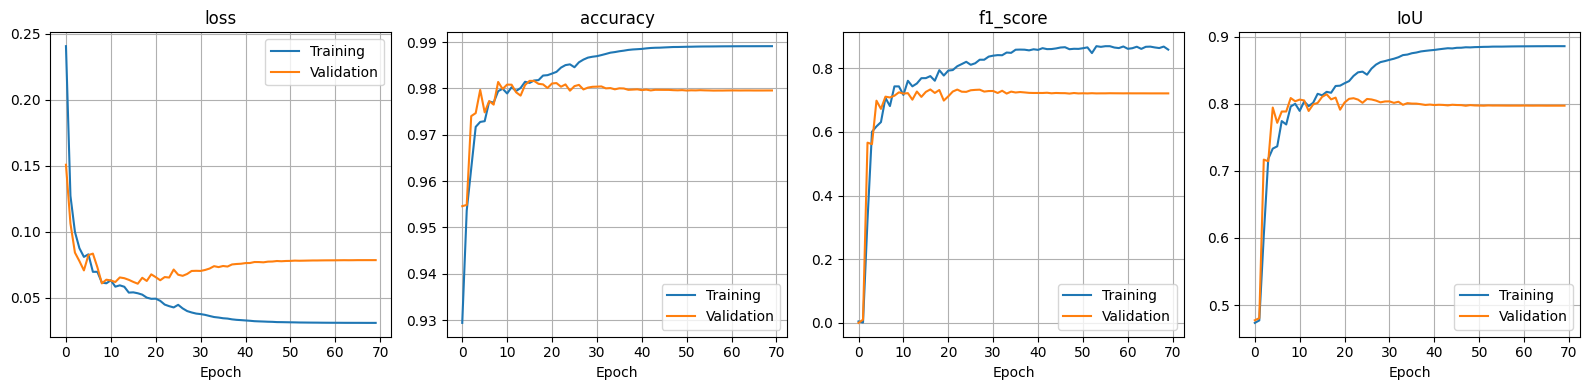

In [ ]:
# # plotting train history
# plot_training_history(train_history)

## Loading the best model

In [ ]:
##Now, load the best model
best_model = ks.models.load_model(os.path.join(PATH_TO_SAVE_MODEL, best_model_name),
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})

# best_model =model

## Visualize model predictions

In [ ]:
# Get predictions from the model
predictions = best_model.predict(x_test, verbose=1)

USER_DETERMINED_THRESHOLD = 0.5
thresholded_predictions  = (predictions  >= USER_DETERMINED_THRESHOLD)
# Removing the color channel
thresholded_predictions_without_color_channel = np.squeeze(thresholded_predictions, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


#AUC

In [ ]:
# Add this section *after* prediction is made with the best model
# i.e., after: predictions = best_model.predict(x_test, verbose=1)

from sklearn.metrics import roc_auc_score

# Flatten masks for AUC computation
y_true_flat = y_test.flatten()
y_score_flat = predictions.flatten()  # Predicted probabilities

In [ ]:
# Bootstrapping AUC
n_iterations = 100
rng = np.random.default_rng(SEED)
bootstrap_aucs = []

for _ in range(n_iterations):
    indices = rng.integers(0, len(y_true_flat), len(y_true_flat))
    y_true_sample = y_true_flat[indices]
    y_score_sample = y_score_flat[indices]

    # Ensure both classes are present in the sample
    if len(np.unique(y_true_sample)) < 2:
        continue

    auc = roc_auc_score(y_true_sample, y_score_sample)
    bootstrap_aucs.append(auc)

In [ ]:
# Calculate statistics
mean_auc = np.mean(bootstrap_aucs)
std_auc = np.std(bootstrap_aucs)
lower_ci = np.percentile(bootstrap_aucs, 2.5)
upper_ci = np.percentile(bootstrap_aucs, 97.5)

# Print AUC statistics
print(f"Bootstrapped AUC: Mean={mean_auc:.4f}, Std={std_auc:.4f}, 95% CI=({lower_ci:.4f}, {upper_ci:.4f})")

# Optional saving
if SAVE_RESULTS:
    auc_df = pd.DataFrame({'AUC Scores': bootstrap_aucs})
    auc_df.to_csv(os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_bootstrapped_auc.csv"), index=False)

Bootstrapped AUC: Mean=0.9717, Std=0.0005, 95% CI=(0.9707, 0.9727)
